# Logistic Regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

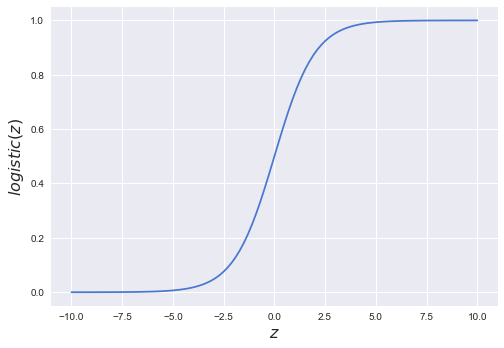

In [2]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)
plt.savefig('B04958_05_01.png', dpi=300, figsize=(5.5, 5.5))

In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


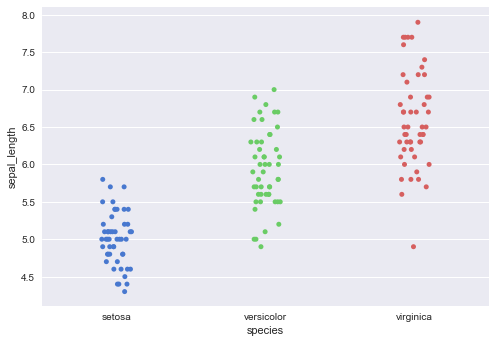

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.savefig('B04958_05_03.png', dpi=300, figsize=(5.5, 5.5))

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


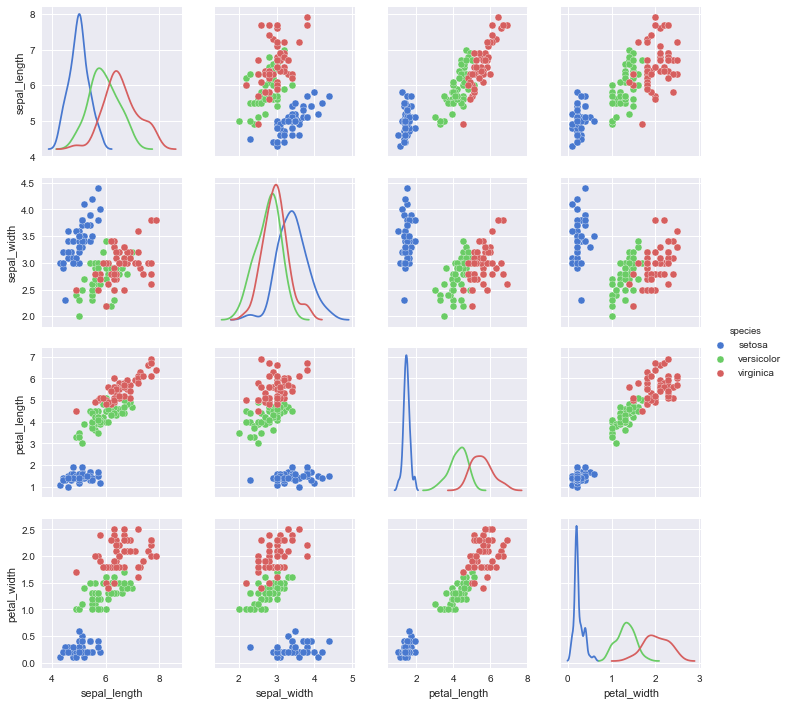

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B04958_05_04.png', dpi=300, figsize=(5.5, 5.5))

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [7]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 41.725531
         Iterations: 13
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [00:21<00:00, 231.98it/s]


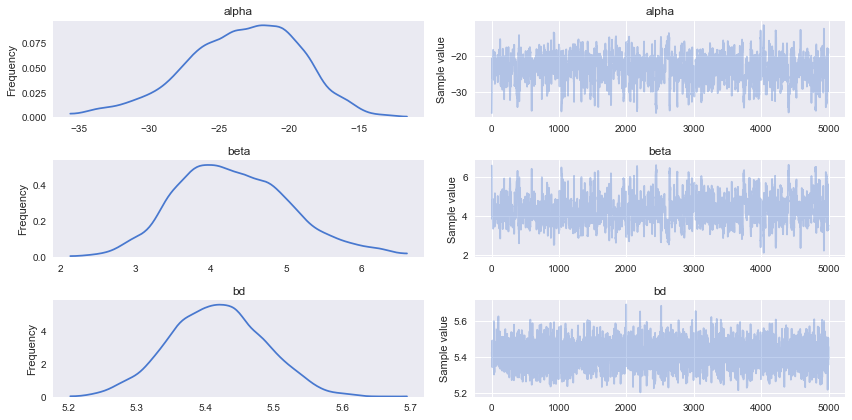

In [8]:
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames)
plt.savefig('B04958_05_05.png', dpi=300, figsize=(5.5, 5.5))

In [9]:
#pm.autocorrplot(trace_0, varnames);

In [10]:
#sns.kdeplot(trace_0['alpha'], cadena_0['beta']);

In [11]:
pm.df_summary(trace_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-23.32,4.07,1.66e-01,-31.63,-15.77
beta,4.31,0.76,3.08e-02,2.87,5.84
bd,5.42,0.07,1.19e-03,5.28,5.55


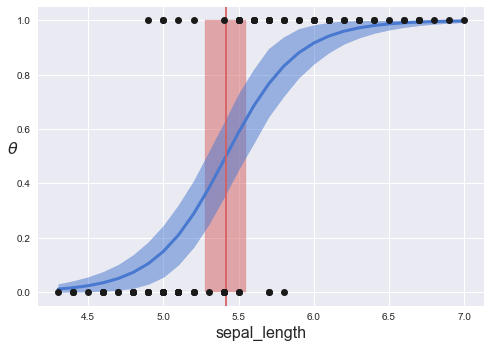

In [12]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))

In [13]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([ 0.14,  0.59,  0.93]), array([False,  True,  True], dtype=bool))

## Multiple logistic regression

In [14]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [17]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_1 = pm.sample(5000, step, start)
    #trace_1 = pm.sample(5000)

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 19.023474
         Iterations: 20
         Function evaluations: 23

100%|██████████| 5000/5000 [00:26<00:00, 185.89it/s]


         Gradient evaluations: 23


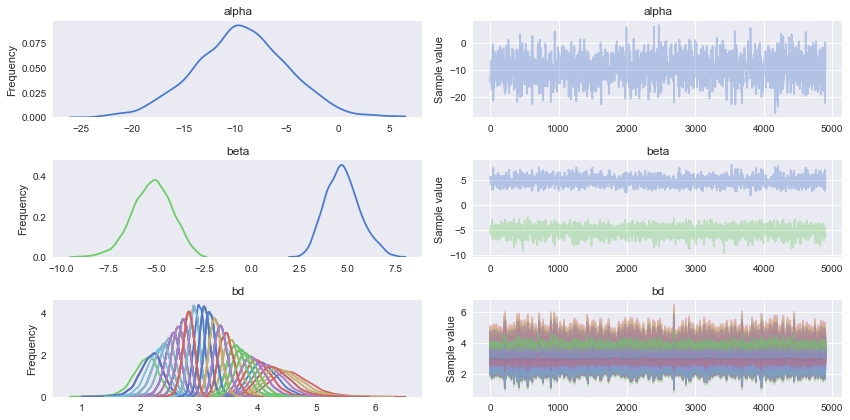

In [18]:
chain_1 = trace_1[100:]
pm.traceplot(chain_1)
plt.savefig('B04958_05_07.png', dpi=300, figsize=(5.5, 5.5))

In [19]:
#pm.df_summary(chain_1, ['alpha', 'beta'])

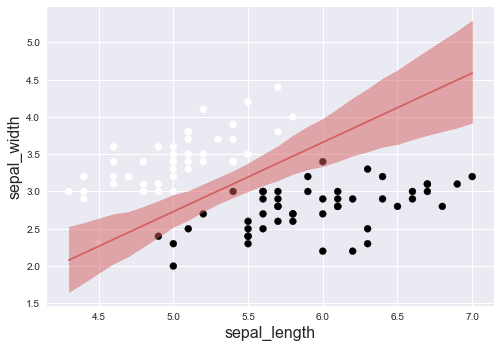

In [20]:
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0)
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_08.png', dpi=300, figsize=(5.5, 5.5))

## Correlated variables

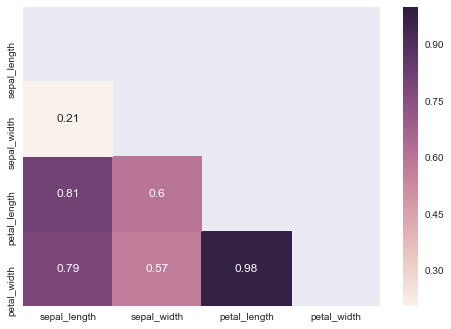

In [21]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True)
plt.savefig('B04958_05_09.png', dpi=300, figsize=(5.5, 5.5))

## Unbalanced Classes

In [22]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [25]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_3 = pm.sample(5000,step, start)

/Users/didi/anaconda2/envs/py3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 12.546309
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 5000/5000 [00:23<00:00, 211.56it/s]


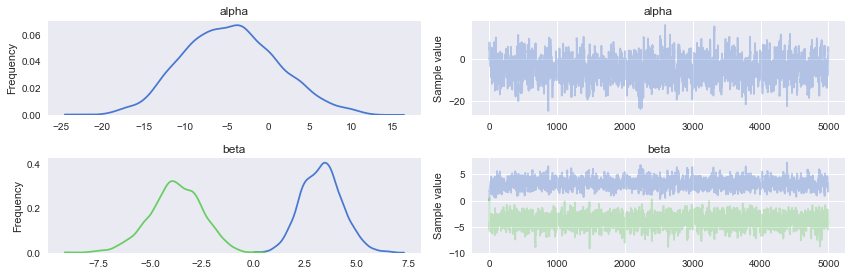

In [26]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [27]:
pm.df_summary(cadena_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.54,5.75,0.18,-15.28,6.88
beta__0,3.30,0.98,0.03,1.43,5.23
beta__1,-3.77,1.27,0.04,-6.18,-1.25


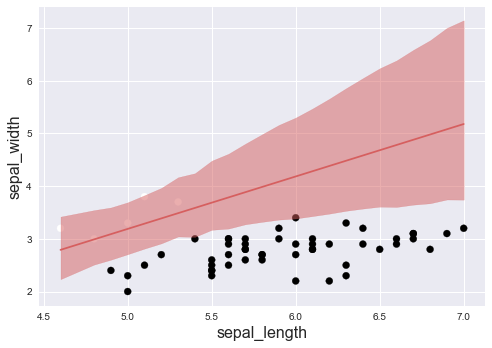

In [28]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_10.png', dpi=300, figsize=(5.5, 5.5))

## Softmax logistic regression (AKA multinomial regression)

In [29]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [30]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(2000, step, start)

Optimization terminated successfully.
         Current function value: 44.793882
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


100%|██████████| 2000/2000 [00:40<00:00, 49.09it/s] 


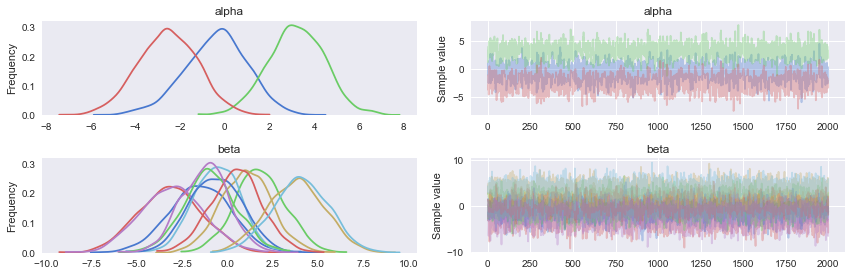

In [31]:
pm.traceplot(trace_s)
plt.savefig('B04958_05_12.png', dpi=300, figsize=(5.5, 5.5))

In [32]:
pm.df_summary(trace_s)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,-0.42,1.41,0.04,-3.18,2.40
alpha__1,3.21,1.27,0.03,0.64,5.52
alpha__2,-2.58,1.34,0.04,-5.31,-0.10
beta__0_0,-1.50,1.69,0.04,-4.92,1.65
beta__0_1,1.04,1.39,0.04,-1.85,3.65
beta__0_2,0.48,1.41,0.04,-2.11,3.50
beta__1_0,1.82,1.39,0.04,-0.89,4.55
beta__1_1,-0.57,1.28,0.04,-3.18,1.76
beta__1_2,-1.24,1.32,0.03,-3.70,1.37
beta__2_0,-3.15,1.76,0.04,-6.54,0.24


In [33]:
#pm.autocorrplot(trace_s, varnames=['alpha']);

In [34]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.97333333333333338

In [35]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_sf = pm.sample(2000, step, start)

Optimization terminated successfully.
         Current function value: 42.147631
         Iterations: 30


100%|██████████| 2000/2000 [00:30<00:00, 65.94it/s] 

         Function evaluations: 34
         Gradient evaluations: 34


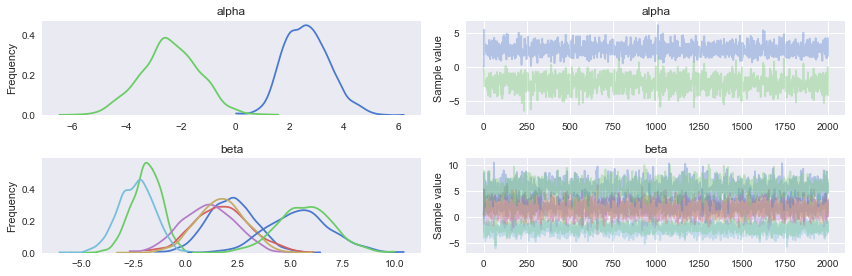

In [36]:
pm.traceplot(trace_sf)
plt.savefig('B04958_05_13.png', dpi=300, figsize=(5.5, 5.5))

In [37]:
pm.df_summary(trace_sf)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.64,0.83,0.02,1.15,4.35
alpha__1,-2.40,1.08,0.03,-4.65,-0.51
beta__0_0,2.16,1.14,0.03,-0.09,4.33
beta__0_1,1.70,1.15,0.03,-0.50,3.93
beta__1_0,-1.88,0.71,0.02,-3.30,-0.53
beta__1_1,-2.37,0.86,0.02,-4.03,-0.74
beta__2_0,1.74,1.34,0.04,-0.48,4.77
beta__2_1,5.41,1.52,0.05,2.72,8.66
beta__3_0,1.09,1.27,0.04,-1.22,3.60
beta__3_1,5.68,1.33,0.04,3.09,8.40


## Linear discriminat Analysis

In [38]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [39]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_lda = pm.sample(5000, step, start)

Optimization terminated successfully.
         Current function value: 68.870583
         Iterations: 15

100%|██████████| 5000/5000 [00:12<00:00, 390.92it/s]


         Function evaluations: 32
         Gradient evaluations: 32


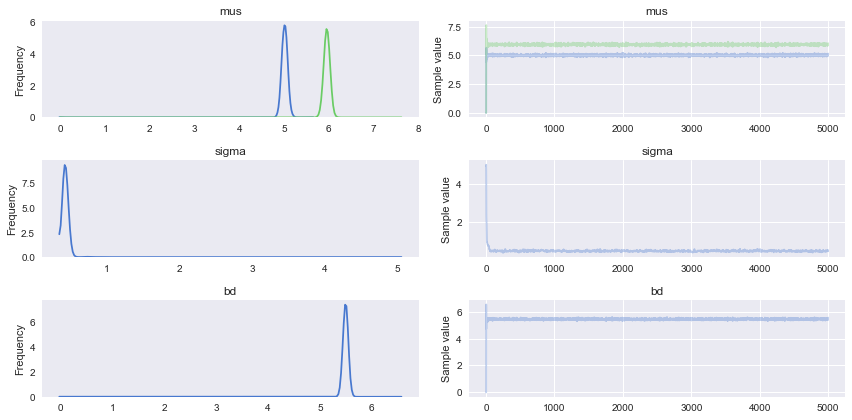

In [40]:
pm.traceplot(trace_lda)
plt.savefig('B04958_05_14.png', dpi=300, figsize=(5.5, 5.5))

In [41]:
pm.df_summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mus__0,5.00,0.14,3.25e-03,4.88,5.12
mus__1,5.93,0.16,3.67e-03,5.81,6.06
sigma,0.46,0.14,8.12e-03,0.39,0.51
bd,5.47,0.14,3.39e-03,5.38,5.56


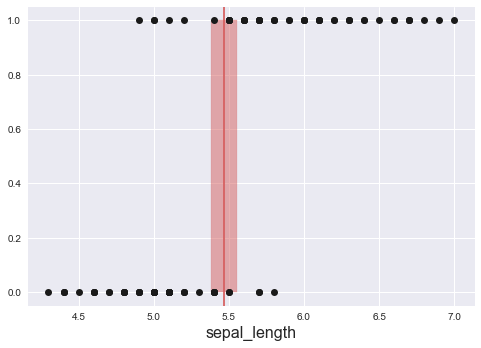

In [42]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)
plt.savefig('B04958_05_15.png', dpi=300, figsize=(5.5, 5.5))

In [43]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running   and using:
Python 3.6.0
IPython 5.1.0
PyMC3 3.0
NumPy 1.11.3
SciPy 0.18.1
Matplotlib 2.0.0
Seaborn 0.7.1
Pandas 0.19.2
